# <font color='red'> Applied Machine Learning Project 2: 

# Salary Prediction for State authorities (Regression) 



### Data Source:

###### salary-information-for-state-authorities.csv

- Context

This is a dataset hosted by the State of New York. The state has an open data platform found here and they update their information according the amount of data that is brought in. Explore New York State using Kaggle and all of the data sources available through the State of New York organization page!

- Acknowledgements

This dataset is maintained using Socrata's API and Kaggle's API. Socrata has assisted countless organizations with hosting their open data and has been an integral part of the process of bringing more data to the public.

This dataset is distributed under the following licenses: Public Domain


link: https://www.kaggle.com/new-york-state/nys-salary-information-for-the-public-sector


### Dataset and features and target value. 

##### Features
- Authority Name - Name of the Public Authority


- Fiscal Year End Date - Date of Fiscal Year end for the authority


- Has Employees - N indicates that the authority reported having no staff. All the remaining fields are blank when authorities report having no staff.This field is blank when the authority reported having staff.


- Last Name - Last name of the employee


- Middle Initial - Middle initial of the employee


- First Name - First name of the employee


- Title - Title of the employee


- Group - Indicates whether the employee’s position is either operational, administrative and clerical, technical and engineering, professional, managerial, or executive.


- Department - Department (if any) that the employee works in. This field is blank if the authority didn’t enter any information.


- Pay Type - Full time (FT) or part time (PT)


- Exempt Indicator - Y/N field to indicate whether the employee is exempt or non-exempt under the Fair Labor Standards Act (FLSA).


- Base Annualized Salary - The annual base salary associated with a particular job title or position For hourly or part-time staff, annualized salary would be the actual wages paid to the individual for the reporting period.


- Actual Salary Paid - The actual salary or wages paid to the individual for the reporting period. This amount could be less than the annualized salary if the individual was employed in the position for less than the full year.


- Overtime Paid - Extra cash payments to the individual for hours worked in excess of normal work week hours, as authorized by the authority’s policies, an employment contract or a collective bargaining agreement. Overtime would include holiday pay.


- Performance Bonus- A cash payment to the individual that does not become part of the base annualized salary. This payment must be linked to the individual meeting clearly defined and measurable performance goals established and approved by the Board of Directors prior to the start of the fiscal year, or detailed in a performance contract approved by the Board. These performance goals should reflect accomplishments that exceed the expected job standards of the position. The amount of the bonus payment should be calculated based on a formula defined in the authority’s performance bonus policy. A performance bonus would include a bonus earned in a prior year but deferred until the reporting year, provided that the payment is consistent with the policy governing other bonuses.


- Extra Pay - Payments made to the individual for unused accrued vacation or personal time, commissions, longevity, as incentives for such purposes as excellent attendance or maintaining proper standing with professional licensure requirements; cash payments to the individual in lieu of an authority’s contribution to the individual’s pension fund or health insurance coverage; or other financial awards to the individual not based on performance goals. The terms and type of extra pay to be awarded to an individual should be defined in collectively bargained or employment contracts.


- Other Compensation - Allowances, reimbursement for authorized expenses, or all other forms of taxable income not included in one of the above categories. This could include adjustments to previously paid compensation to correct payment errors.


- Paid By Another Entity - Y/N field that indicates whether the individual is paid by another entity to perform the work of the Authority.


- Paid by State or Local Government - ‘Y’ indicates that the individual was paid by a State or local government to perform the work of the Authority, and is blank otherwise. This field is completed only when the Paid by Another Entity field is ‘Y’.


##### Target value


- Total Compensation - Total payments made to the individual during the year including any overtime, bonus, extra, or other compensation amounts. This field is the sum of the Actual Salary Paid, Overtime Paid, Performance Bonus, Extra Pay and Other Compensation fields.

### Importing libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score 

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def null_percentage(df):
    '''
    input: dataframe
    output: Null percentage of columns in dataframe
    
    '''
    percent = df.isnull().sum()/len(df.index)*100
    df = pd.DataFrame(round(percent,2),columns=['null_percent'])
    
    
    return df[df['null_percent']!=0.00].sort_values('null_percent',ascending=False)

In [3]:
def cat_count(df):
    '''
    input: dataframe
    output: Give counts of number of categories in a column
    
    '''
    counts = {}
    cat_cols = df.select_dtypes(include=['object']).columns
    for i in range(len(cat_cols)):
        counts[cat_cols[i]] = len(df[cat_cols[i]].value_counts())
    
    return pd.DataFrame(data=counts.values(), index=counts.keys(),columns=['Categories Counts']).sort_values('Categories Counts',ascending=False)

In [4]:
def dummy_variables(df,cols):
    '''
    input: dataframe and categorical variable(to make dummy variable)
    output: dataframe with dummy variables
    
    '''
    for i in range(len(cols)):
        dummies = pd.get_dummies(df[cols[i]],drop_first=False)
        df = df.join(dummies)
        
    df.drop(cols,inplace=True,axis=1)
    return df

In [5]:
scores = {}
errors = {}
R2 = {}

def model_train(name,model,X_train,y_train,X_test,y_test):
    _ = model.fit(X_train, y_train)
    predictions = _.predict(X_test)
    scores[name] = _.score(X_test, y_test)
    errors[name] = mean_squared_error(y_test,predictions)
    R2[name] = np.mean(r2_score(y_test,predictions))
    
    print(name, "Model Train Score:", _.score(X_train, y_train))
    print(name, "Model Score:", _.score(X_test, y_test))    
    print(name, "R2 score:",np.mean(r2_score(y_test,predictions)))
    print(name, "Model Error:",mean_squared_error(y_test,predictions))
    
    
    plt.scatter(y_test, predictions,  color='gray')
    plt.plot(y_test, predictions, color='red', linewidth=0.5)
    plt.show()
    
    

In [6]:
avg_cv = {}

def cross_v(name,model,X_train,y_train): 
    scores = cross_val_score(model,X_train,y_train, cv=5)
    print("Cross validation scores: {}".format(scores))
    print("Average cross-validation scroe: {:.2f}".format(scores.mean()))
    avg_cv[name] = scores.mean()

In [7]:
def grid_search(name,model,grid_list,X_train,y_train,cvs=5):
    
    grid_search = GridSearchCV(model, param_grid = grid_list, n_jobs = -1, cv = cvs, scoring = 'neg_mean_squared_error',verbose=1) 
    grid_search.fit(X_train,y_train)
    print(name, "Best Score :",grid_search.best_score_)
    print(name, "Best Parameters :",grid_search.best_params_)

### Importing Data

In [8]:
df = pd.read_csv('salary-information-for-state-authorities.csv')
df["Fiscal Year End Date"] = pd.to_datetime(df['Fiscal Year End Date'])

### Exploratory Data Analysis (EDA)

In [9]:
df.head()

,Authority Name,Fiscal Year End Date,Has Employees,Last Name,Middle Initial,First Name,Title,Group,Department,Pay Type,Exempt Indicator,Base Annualized Salary,Actual Salary Paid,Overtime Paid,Performance Bonus,Extra Pay,Other Compensation,Total Compensation,Paid By Another Entity,Paid by State or Local Government
0,Agriculture and New York State Horse Breeding ...,2017-12-31,NaN,Richardson,L,Connie,Executive Assistant,Administrative and Clerical,NaN,FT,Y,45840.00,45840.00,NaN,NaN,NaN,NaN,45840.00,N,NaN
1,Erie County Fiscal Stability Authority,2017-12-31,NaN,Panek,NaN,Gordon,Financial Analyst,Administrative and Clerical,NaN,FT,Y,56538.00,58423.00,NaN,NaN,NaN,NaN,58423.00,N,NaN
2,Erie County Fiscal Stability Authority,2017-12-31,NaN,Pawlik,NaN,Susan,Office Manager,Administrative and Clerical,NaN,FT,Y,34972.00,36242.00,NaN,NaN,NaN,NaN,36242.00,N,NaN
3,Erie County Fiscal Stability Authority,2017-12-31,NaN,Vetter,NaN,Kenneth,Executive Director,Executive,NaN,FT,Y,129348.08,151364.86,NaN,NaN,NaN,NaN,151364.86,N,NaN
4,Erie County Medical Center Corporation,2017-12-31,NaN,Abafita,NaN,Aziza,General Duty Nurse,Professional,7700 Acute FL 6 Zone 2,FT,N,78474.24,76674.74,25311.26,NaN,2259.4,NaN,104245.40,N,NaN


In [10]:
print("Shape: ",df.shape)
print("\nColumns: ", list(df.columns))


Shape:  (755713, 20)

Columns:  ['Authority Name', 'Fiscal Year End Date', 'Has Employees', 'Last Name', 'Middle Initial', 'First Name', 'Title', 'Group', 'Department', 'Pay Type', 'Exempt Indicator', 'Base Annualized Salary', 'Actual Salary Paid', 'Overtime Paid', 'Performance Bonus', 'Extra Pay', 'Other Compensation', 'Total Compensation', 'Paid By Another Entity', 'Paid by State or Local Government']


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755713 entries, 0 to 755712
Data columns (total 20 columns):
Authority Name                       755713 non-null object
Fiscal Year End Date                 755713 non-null datetime64[ns]
Has Employees                        19 non-null object
Last Name                            755694 non-null object
Middle Initial                       426875 non-null object
First Name                           755694 non-null object
Title                                755694 non-null object
Group                                755694 non-null object
Department                           748879 non-null object
Pay Type                             755694 non-null object
Exempt Indicator                     755694 non-null object
Base Annualized Salary               750860 non-null float64
Actual Salary Paid                   739661 non-null float64
Overtime Paid                        573150 non-null float64
Performance Bonus                    31421

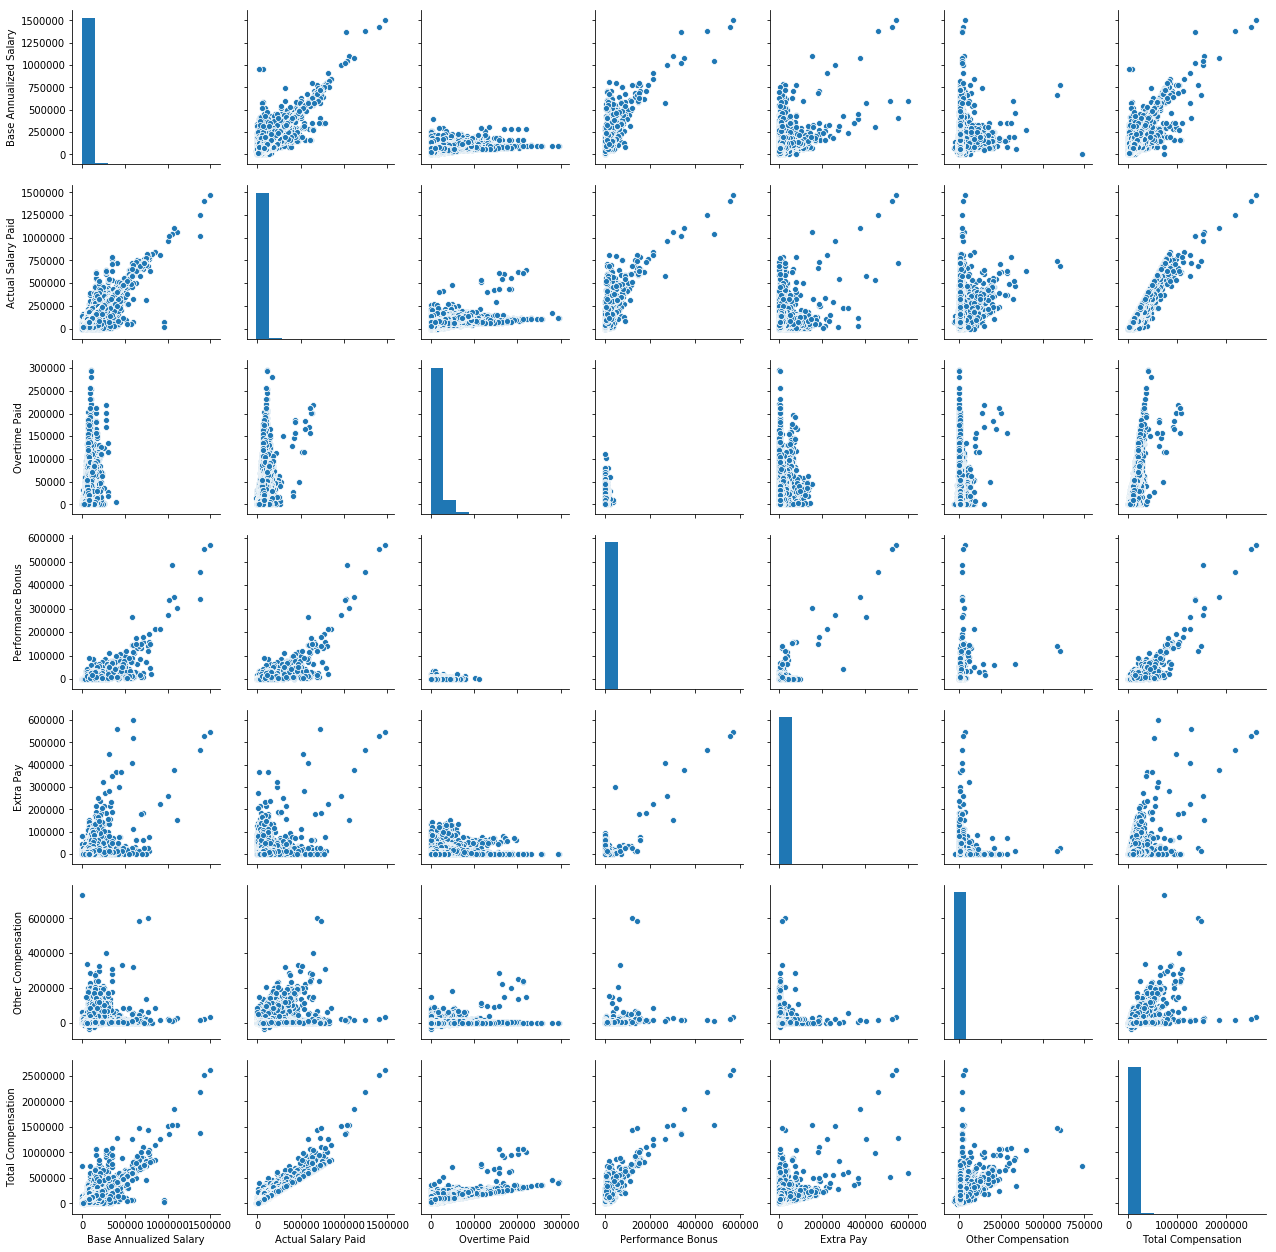

In [12]:
sns.pairplot(df)

- Relation between Features and Target 

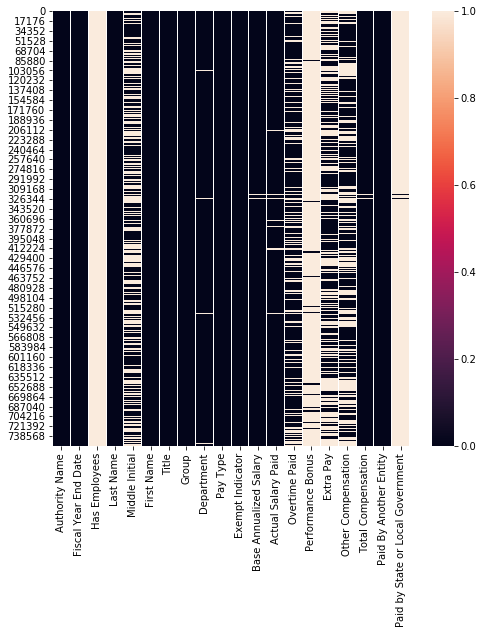

In [13]:
plt.figure(figsize=(8,8))
sns.heatmap(df.isna())

- These columns have null values:

Has Employees, Paid by State or Local Government, Performance Bonus, Middle Initial, Extra Pay, Other Compensation, 
Overtime Paid, Actual Salary Paid, Department, Base Annualized Salary, Total Compensation	

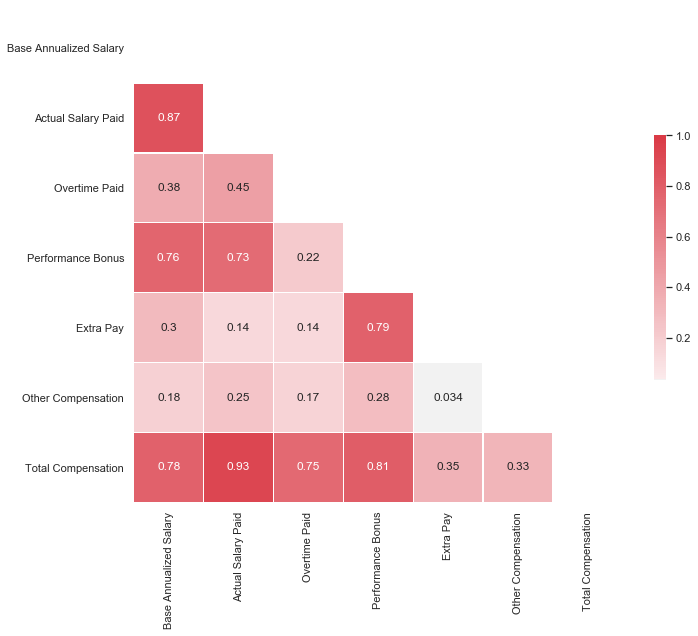

In [14]:
sns.set(style="white")
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

- 'Base Annualized Salary', 'Actual Salary Paid', 'Overtime Paid' and 'Performance Bonus'
has correlation with Total Compensation (Target)

### Preprocessing
- Dealing with missing values

In [15]:
null_percentage(df)

,null_percent
Has Employees,100.00
Paid by State or Local Government,99.51
Performance Bonus,95.84
Middle Initial,43.51
Extra Pay,41.81
Other Compensation,39.08
Overtime Paid,24.16
Actual Salary Paid,2.12
Department,0.90
Base Annualized Salary,0.64


###### This columns has null values.

In [16]:
df["Has Employees"].fillna(value="Yes",inplace=True)
df["Paid by State or Local Government"].fillna(value="N",inplace=True)

df["Performance Bonus"].fillna(value=0,inplace=True)
df["Extra Pay"].fillna(value=0,inplace=True)
df["Other Compensation"].fillna(value=0,inplace=True)
df["Overtime Paid"].fillna(value=0,inplace=True)
df["Total Compensation"].fillna(value=0,inplace=True)
null_percentage(df)

,null_percent
Middle Initial,43.51
Actual Salary Paid,2.12
Department,0.90
Base Annualized Salary,0.64


In [17]:
cols = ["Middle Initial","Department"]
df.drop(columns=cols,axis=1,inplace=True)
null_percentage(df)

,null_percent
Actual Salary Paid,2.12
Base Annualized Salary,0.64


###### Now deleting the rest of the Null Values

In [18]:
df.dropna(inplace=True,axis=0)
null_percentage(df)

,null_percent


In [19]:
df['Has Employees'].value_counts()

Yes    738654
Name: Has Employees, dtype: int64

In [20]:
df['Paid by State or Local Government'].value_counts()

N    738654
Name: Paid by State or Local Government, dtype: int64

In [21]:
df['Paid By Another Entity'].value_counts()

N    738591
Y        63
Name: Paid By Another Entity, dtype: int64

###### 'Has Employees' and 'Paid By Another Entity' has all the values same, so it's better to drop the both columns.

In [22]:
df.drop(["Has Employees","Paid by State or Local Government"],axis=1,inplace=True)

In [23]:
null_percentage(df)

,null_percent


- Now converting Caterigorical columns

By creating Dummy Variables and Mapping

In [24]:
cat_count(df)

,Categories Counts
Last Name,73684
First Name,35381
Title,20709
Authority Name,40
Group,6
Pay Type,2
Exempt Indicator,2
Paid By Another Entity,2


###### Dropping some irrelevant columns

In [25]:
cols = ["Last Name" , "First Name" , "Title" , "Authority Name"]
df.drop(columns=cols,axis=1,inplace=True)

###### Converting categorical columns to dummy variables

In [26]:
cat_cols = ["Group", "Pay Type", "Exempt Indicator"]
df = dummy_variables(df,cat_cols)

###### Mapping

In [27]:
df['Paid By Another Entity'] = df['Paid By Another Entity'].map({'Y': 1, 'N': 0})

In [28]:
cat_count(df)

,Categories Counts


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738654 entries, 0 to 755712
Data columns (total 19 columns):
Fiscal Year End Date           738654 non-null datetime64[ns]
Base Annualized Salary         738654 non-null float64
Actual Salary Paid             738654 non-null float64
Overtime Paid                  738654 non-null float64
Performance Bonus              738654 non-null float64
Extra Pay                      738654 non-null float64
Other Compensation             738654 non-null float64
Total Compensation             738654 non-null float64
Paid By Another Entity         738654 non-null int64
Administrative and Clerical    738654 non-null uint8
Executive                      738654 non-null uint8
Managerial                     738654 non-null uint8
Operational                    738654 non-null uint8
Professional                   738654 non-null uint8
Technical and Engineering      738654 non-null uint8
FT                             738654 non-null uint8
PT                

###### 'Fiscal Year End Date' has datatime format so I'll extract year and month from that column and then drop the 'Fiscal Year End Date' column.

In [30]:
df['Fiscal Year'] = df['Fiscal Year End Date'].dt.year
df['Fiscal Month'] = df['Fiscal Year End Date'].dt.month

df.drop("Fiscal Year End Date",axis=1,inplace=True)

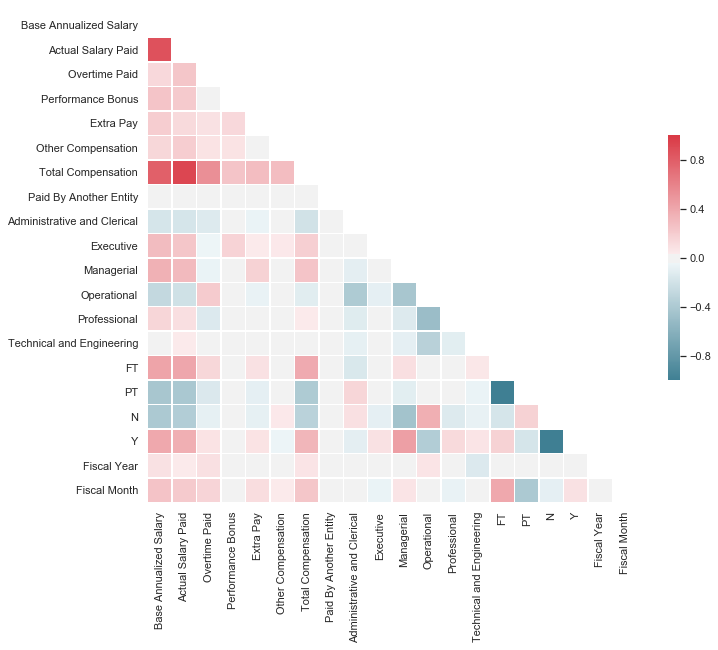

In [31]:
sns.set(style="white")
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

###### 'FT'  ,  'N'  and  'Base Annualized Salary'  these three columns has high correlation, So I'll drop these columns.

In [32]:
df.drop(['FT','N','Base Annualized Salary'],axis=1,inplace=True)

### Splitting the data into train and test.

In [33]:
df.shape

(738654, 17)

In [34]:
X,y = df.drop('Total Compensation',axis=1),df['Total Compensation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


## Training 

### Bagging with Polynomial and Linear Regression

- LinearRegression Model

Linear Regression (Bagging) Model Train Score: 1.0
Linear Regression (Bagging) Model Score: 1.0
Linear Regression (Bagging) R2 score: 1.0
Linear Regression (Bagging) Model Error: 9.194299108726401e-21


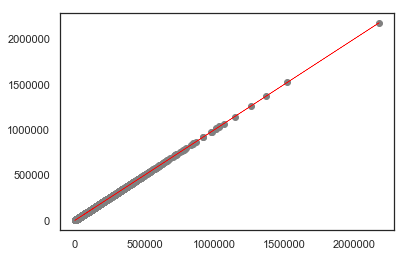

Wall time: 56.7 s


In [35]:
%%time
lm = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
bag_reg = BaggingRegressor(lm, n_estimators=100, max_samples=700, bootstrap=True, random_state=0)
model_train("Linear Regression (Bagging)",bag_reg,X_train,y_train,X_test,y_test)


- Polynomial Regression Model

Polynomial Regression (Bagging) Model Train Score: 1.0
Polynomial Regression (Bagging) Model Score: 1.0
Polynomial Regression (Bagging) R2 score: 1.0
Polynomial Regression (Bagging) Model Error: 9.194299108726401e-21


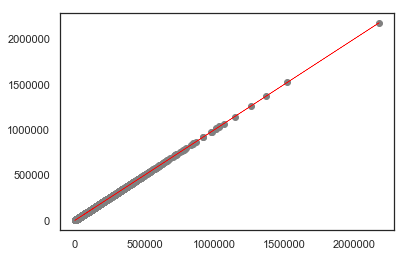

Wall time: 59.9 s


In [36]:
%%time

poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lm = LinearRegression()
bag_reg = BaggingRegressor(lm, n_estimators=100, max_samples=700, bootstrap=True, random_state=0)
model_train("Polynomial Regression (Bagging)",bag_reg,X_train,y_train,X_test,y_test)


### Pasting with Ridge and Lasso

- Ridge Regressor

Ridge (Pasting) Model Train Score: 1.0
Ridge (Pasting) Model Score: 1.0
Ridge (Pasting) R2 score: 1.0
Ridge (Pasting) Model Error: 4.99165319637715e-13


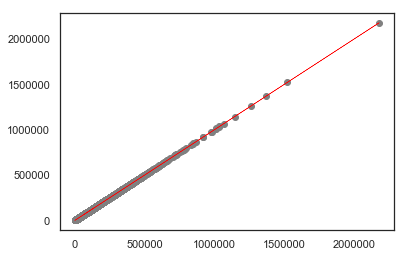

Wall time: 38.1 s


In [37]:
%%time
rdg = Ridge(alpha=0.02)
pas_reg = BaggingRegressor(rdg, n_estimators=100, max_samples=500, bootstrap=False, random_state=0)

model_train('Ridge (Pasting)',pas_reg,X_train,y_train,X_test,y_test)

- Lasso Regressor

Lasso (Pasting) Model Train Score: 0.9999999999999885
Lasso (Pasting) Model Score: 0.9999999999999892
Lasso (Pasting) R2 score: 0.9999999999999892
Lasso (Pasting) Model Error: 1.9941200646694922e-05


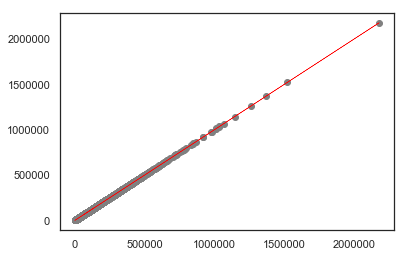

Wall time: 14.9 s


In [38]:
%%time
laso = Lasso(alpha = .02)
pas_reg = BaggingRegressor(laso, n_estimators=100, max_samples=500, bootstrap=False, random_state=0)

model_train('Lasso (Pasting)',pas_reg,X_train,y_train,X_test,y_test)

### AdaBoosting with Linear SVR and KNN Regressor

- Linear SVR

Linear SVR (Adaboost) Model Train Score: 0.9999999999999998
Linear SVR (Adaboost) Model Score: 0.9999999999999997
Linear SVR (Adaboost) R2 score: 0.9999999999999997
Linear SVR (Adaboost) Model Error: 6.557325912854016e-07


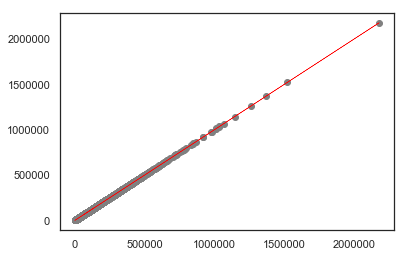

Wall time: 3min 54s


In [39]:
%%time

lsvm = LinearSVR(C=0.001, random_state=1210)
ada_reg = AdaBoostRegressor(lsvm, n_estimators= 10, learning_rate= .5, random_state = 0)
model_train("Linear SVR (Adaboost)",ada_reg,X_train,y_train,X_test,y_test)

- KNN Regressor

KNN (Adaboost) Model Train Score: 0.999100341019413
KNN (Adaboost) Model Score: 0.9988427791531438
KNN (Adaboost) R2 score: 0.9988427791531438
KNN (Adaboost) Model Error: 2132256.107219603


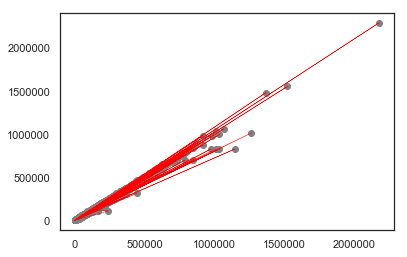

Wall time: 4min 24s


In [40]:
%%time

knn = KNeighborsRegressor(n_neighbors=3)
ada_reg = AdaBoostRegressor(knn, n_estimators=2 , learning_rate= .5, random_state = 0)
model_train("KNN (Adaboost)",ada_reg,X_train,y_train,X_test,y_test)


### Gradiant Boosting

Gradient Boosting Model Train Score: 0.9966177016738297
Gradient Boosting Model Score: 0.9955471883316506
Gradient Boosting R2 score: 0.9955471883316506
Gradient Boosting Model Error: 8204600.617012598


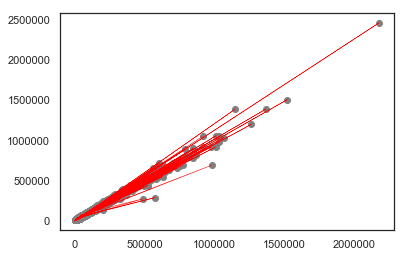

Wall time: 25.1 s


In [41]:
%%time

grd_reg = GradientBoostingRegressor( max_depth= 3, n_estimators= 50, learning_rate= .5, random_state = 0)
model_train("Gradient Boosting",grd_reg,X_train,y_train,X_test,y_test)


## PCA 

In [42]:
pca = PCA(n_components= .97)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

### Linear Regression

Linear Regression Model Train Score: 0.9893514372035527
Linear Regression Model Score: 0.9904364451204702
Linear Regression R2 score: 0.9904364451204702
Linear Regression Model Error: 17621483.70728409


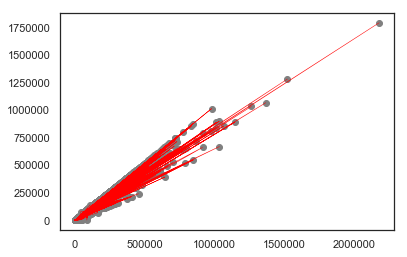

Wall time: 2.93 s


In [43]:
%%time

lm = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
model_train('Linear Regression',lm,X_train_reduced,y_train,X_test_reduced,y_test)

### Polynomial Regressor

Polynomial Regressor Model Train Score: 0.9893514372035527
Polynomial Regressor Model Score: 0.9904364451204702
Polynomial Regressor R2 score: 0.9904364451204702
Polynomial Regressor Model Error: 17621483.707284104


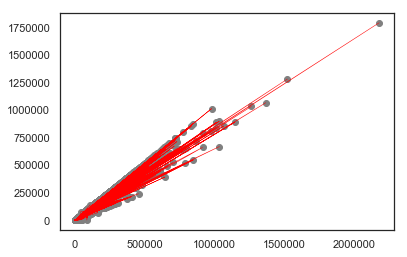

Wall time: 3.06 s


In [44]:
%%time

poly = PolynomialFeatures(1)
X_train_poly = poly.fit_transform(X_train_reduced)
X_test_poly = poly.transform(X_test_reduced)

lm = LinearRegression()
model_train('Polynomial Regressor',lm,X_train_poly,y_train,X_test_poly,y_test)


### K Neighbors Regressor

KNN Model Train Score: 0.9969840967887741
KNN Model Score: 0.9939702051977444
KNN R2 score: 0.9939702051977444
KNN Model Error: 11110296.558620073


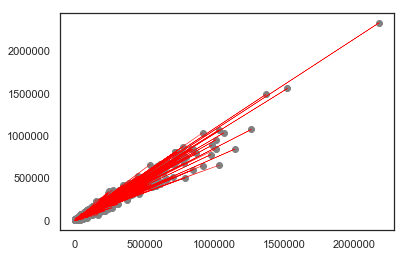

Wall time: 10.6 s


In [45]:
%%time

knn = KNeighborsRegressor(n_neighbors=3)
model_train('KNN',knn,X_train_reduced,y_train,X_test_reduced,y_test)

### Ridge Regressor

Ridge Model Train Score: 0.9893514372035527
Ridge Model Score: 0.9904364451204702
Ridge R2 score: 0.9904364451204702
Ridge Model Error: 17621483.707284123


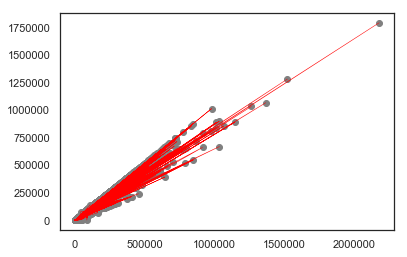

Wall time: 2.93 s


In [46]:
%%time

rdg = Ridge(alpha=0.02)
model_train('Ridge',rdg,X_train_reduced,y_train,X_test_reduced,y_test)

### Lasso Regressor

Laaso Model Train Score: 0.9893514372035527
Laaso Model Score: 0.9904364451205891
Laaso R2 score: 0.990436445120589
Laaso Model Error: 17621483.707065295


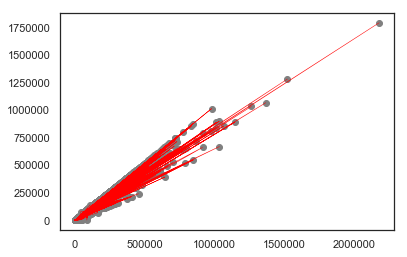

Wall time: 2.93 s


In [47]:
%%time

las = Lasso(alpha=0.02)
model_train('Laaso',las,X_train_reduced,y_train,X_test_reduced,y_test)

### Linear SVM

Linear SVM Model Train Score: -1.8119865184907715
Linear SVM Model Score: -1.8243348336779839
Linear SVM R2 score: -1.8243348336779839
Linear SVM Model Error: 5204024118.907846


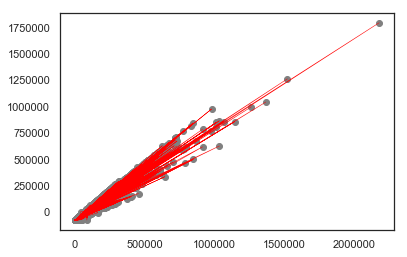

Wall time: 41.1 s


In [48]:
%%time

lsvm = LinearSVR(C=0.001, random_state=1210)
model_train('Linear SVM',lsvm,X_train_reduced,y_train,X_test_reduced,y_test)

### Kernalized SVM

In [49]:
X_tr = X_train.sample(frac=0.05,random_state=200)
y_tr = y_train[X_tr.index]
X_tr_reduced = pca.transform(X_tr)

X_te = X_test.sample(frac=0.05,random_state=200)
y_te = y_test[X_te.index]
X_te_reduced = pca.transform(X_te)

Kernalized SVM Model Train Score: 0.0004953640212190802
Kernalized SVM Model Score: 0.00014817112227250018
Kernalized SVM R2 score: 0.00014817112227250018
Kernalized SVM Model Error: 1769759276.7972775


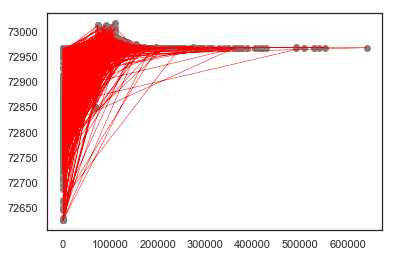

Wall time: 1min 33s


In [50]:
%%time

ksvm = SVR(kernel='rbf', C = 10, gamma = .001)
model_train('Kernalized SVM',ksvm,X_tr_reduced,y_tr,X_te_reduced,y_te)

# Deep Learning

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.utils import np_utils,to_categorical
from keras.losses import MSE                  


Using TensorFlow backend.


In [52]:
X_train.shape

(494898, 16)

In [53]:
# step 1: build the model
model = Sequential()
model.add(Dense(64, input_dim = 16, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [54]:
# step 2: compile the model
model.compile(loss = MSE, optimizer = 'adam', metrics = ['accuracy'])

# step 3: train the model
history = model.fit(X_train, y_train, batch_size= 256, epochs=30,validation_split=0.1)

Train on 445408 samples, validate on 49490 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
445408/445408 [==============================] - 4s 10us/sample - loss: 83268453.8647 - acc: 2.2451e-05 - val_loss: 18739.9850 - val_acc: 0.0000e+00
Epoch 2/30
445408/445408 [==============================] - 4s 9us/sample - loss: 23512.1401 - acc: 2.2451e-05 - val_loss: 8279.9889 - val_acc: 0.0000e+00
Epoch 3/30
445408/445408 [==============================] - 4s 9us/sample - loss: 10525.5765 - acc: 2.2451e-05 - val_loss: 16229.5476 - val_acc: 0.0000e+00
Epoch 4/30
445408/445408 [==============================] - 4s 9us/sample - loss: 20440.8291 - acc: 2.2451e-05 - val_loss: 4035.4180 - val_acc: 0.0000e+00
Epoch 5/30
445408/445408 [==============================] - 4s 10us/sample - loss: 14207.8594 - acc: 2.2451e-05 - val_loss: 179148.9334 - val_acc: 0.0000e+00
Epoch 6/30
445408/445408 [==============================] - 4s 9us/sample - loss: 122008.5063 - acc: 2.2451e-05 - val

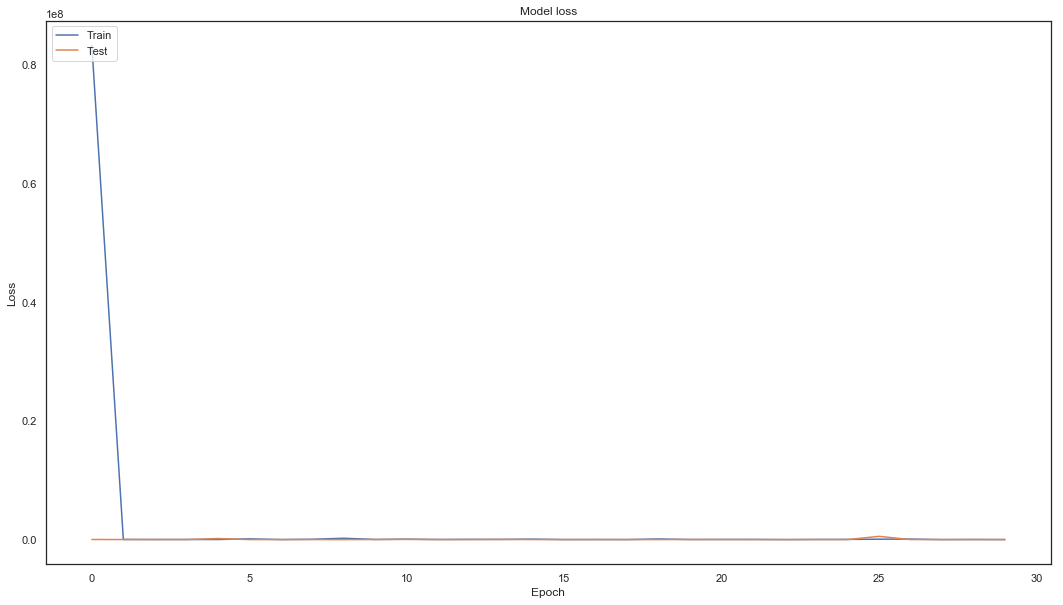

In [55]:
plt.figure(figsize=(18,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [56]:
predictions = model.predict(X_test)

print("Deep Learning R2 score:",np.mean(r2_score(y_test,predictions)))
print("Deep learning Model Error:",mean_squared_error(y_test,predictions))
    

Deep Learning R2 score: 0.9999998965219515
Deep learning Model Error: 190.66516252166275


### Scores of All models

In [57]:
score_df = (pd.DataFrame(data=scores.values(),columns=['Best Score'],index=scores.keys())).sort_values(by='Best Score',ascending=False).reset_index()
score_df.columns = ['Model','Best Score']

r2 = (pd.DataFrame(data=R2.values(),columns=['R2'],index=R2.keys())).sort_values(by='R2',ascending=False).reset_index()
r2.columns = ['Model','R2']

errors_df = (pd.DataFrame(data=errors.values(),columns=['MSE'],index=errors.keys())).sort_values(by='MSE',ascending=True).reset_index()
errors_df.columns = ['Model','MSE']

avg_cv_df = (pd.DataFrame(data=avg_cv.values(),columns=['CV Score'],index=avg_cv.keys())).sort_values(by='CV Score',ascending=False).reset_index()
avg_cv_df.columns = ['Model','CV Score']

In [58]:
#Score Comparison
scr = pd.read_csv('score_df.csv')
scr.drop(['Unnamed: 0'],axis=1,inplace=True)
scr.columns = ['Model','Best Score (Before PCA)']
scr.set_index(['Model'],inplace=True)

score_df.columns = ['Model','Best Score (After PCA)']
score_df.set_index(['Model'],inplace=True)
score_comparison = scr.join(score_df)

In [59]:
#New Model Score
new_scr = scr.join(score_df,how='right')

new_scr = new_scr.loc[['Linear Regression (Bagging)', 'Polynomial Regression (Bagging)',
       'Ridge (Pasting)', 'Linear SVR (Adaboost)', 'Lasso (Pasting)',
       'KNN (Adaboost)', 'Gradient Boosting']]

new_scr.drop(['Best Score (Before PCA)'],axis=1,inplace=True)
new_scr.columns = ['Best Score']


In [60]:
#Error Comparison
err = pd.read_csv('errors.csv')
err.drop(['Unnamed: 0'],axis=1,inplace=True)
err.columns = ['Model','MSE (Before PCA)']
err.set_index(['Model'],inplace=True)

errors_df.columns = ['Model','MSE (After PCA)']
errors_df.set_index(['Model'],inplace=True)
err_comparison = err.join(errors_df)

In [61]:
#New Model error
new_err = err.join(errors_df,how='right')

new_err = new_err.loc[['Linear Regression (Bagging)', 'Polynomial Regression (Bagging)',
       'Ridge (Pasting)', 'Linear SVR (Adaboost)', 'Lasso (Pasting)',
       'KNN (Adaboost)', 'Gradient Boosting']]


new_err.drop(['MSE (Before PCA)'],axis=1,inplace=True)
new_err.columns = ['MSE']


In [62]:
#r2 Comparison
r2__ = pd.read_csv('Regression_r2.csv')
r2__.drop(['Unnamed: 0'],axis=1,inplace=True)
r2__.columns = ['Model','r2 (Before PCA)']
r2__.set_index(['Model'],inplace=True)

r2.columns = ['Model','r2 (After PCA)']
r2.set_index(['Model'],inplace=True)
r2_comparison = r2__.join(r2)

In [63]:
#New Model r2
new_r2 = r2__.join(r2,how='right')

new_r2 = new_r2.loc[['Linear Regression (Bagging)', 'Polynomial Regression (Bagging)',
       'Ridge (Pasting)', 'Linear SVR (Adaboost)', 'Lasso (Pasting)',
       'KNN (Adaboost)', 'Gradient Boosting']]


new_r2.drop(['r2 (Before PCA)'],axis=1,inplace=True)
new_r2.columns = ['r2']


In [64]:
score_comparison

,Best Score (Before PCA),Best Score (After PCA)
Model,,
Linear Regression,1.000000,0.990436
Polynomial Regressor,1.000000,0.990436
Ridge,1.000000,0.990436
Laaso,1.000000,0.990436
Linear SVM,1.000000,-1.824335
KNN,0.999142,0.993970
Kernalized SVM,-0.000087,0.000148


- Best Score decreased after PCA

In [65]:
r2_comparison

,r2 (Before PCA),r2 (After PCA)
Model,,
Linear Regression,1.000000,0.990436
Polynomial Regressor,1.000000,0.990436
Ridge,1.000000,0.990436
Laaso,1.000000,0.990436
Linear SVM,1.000000,-1.824335
KNN,0.999142,0.993970
Kernalized SVM,-0.000087,0.000148


- r2 decreased after PCA

In [66]:
err_comparison

,MSE (Before PCA),MSE (After PCA)
Model,,
Linear Regression,6.620212e-21,1.762148e+07
Ridge,6.952360e-21,1.762148e+07
Polynomial Regressor,1.307369e-18,1.762148e+07
Laaso,1.116676e-07,1.762148e+07
Linear SVM,3.960615e-06,5.204024e+09
KNN,1.581246e+06,1.111030e+07
Kernalized SVM,1.858502e+09,1.769759e+09


- MSE increased after PCA

- overall the PCA is not improving the score

In [67]:
new_scr

,Best Score
Model,
Linear Regression (Bagging),1.000000
Polynomial Regression (Bagging),1.000000
Ridge (Pasting),1.000000
Linear SVR (Adaboost),1.000000
Lasso (Pasting),1.000000
KNN (Adaboost),0.998843
Gradient Boosting,0.995547


In [68]:
new_r2

,r2
Model,
Linear Regression (Bagging),1.000000
Polynomial Regression (Bagging),1.000000
Ridge (Pasting),1.000000
Linear SVR (Adaboost),1.000000
Lasso (Pasting),1.000000
KNN (Adaboost),0.998843
Gradient Boosting,0.995547


In [69]:
new_err

,MSE
Model,
Linear Regression (Bagging),9.194299e-21
Polynomial Regression (Bagging),9.194299e-21
Ridge (Pasting),4.991653e-13
Linear SVR (Adaboost),6.557326e-07
Lasso (Pasting),1.994120e-05
KNN (Adaboost),2.132256e+06
Gradient Boosting,8.204601e+06


### Linear Regression (before PCA) is clearly the best model 
- Best score
- Best R2
- Best Cross Validation Score 
- least Mean Squared Error (MSE) - Almost Comparable with Ridge Regressor. 
- Best Interpretability
- Least Running Time